In [10]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 70
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os 
%matplotlib inline
from scipy.stats import chisquare

### Changement des noms des colonnes

In [11]:
# De manière générale, les premières cells sont similaires à celle des autres notebook d'Alexandre
# et d'Adrien

sns.set_style('darkgrid')

NewColName = ["id","age","sexe","nationalite","etudiant_IMT","musique/Replique",
              "sw_rep_1", "sw_rep_2","ter_mus_1","ter_mus_2","rl_rep_1","rl_rep_2",
             "tit_mus_1","tit_mus_2","sw_mus_1","sw_mus_2","tit_rep_1","tit_rep_2",
             "rl_mus_1","rl_mus_2","lotr_mus_1","lotr_mus_2","ter_rep_1","ter_rep_2",
             "lotr_rep_1","lotr_rep_2","sw_nbr_vis", "sw_age_vis","rl_nbr_vis","rl_age_vis",
             "tit_nbr_vis","tit_age_vis","lotr_nbr_vis","lotr_age_vis","ter_nbr_vis","ter_age_vis",
             "répliques","musique","histoire","revoir_film","enfance","emotion"]


# ### Clean de sw_rep_2

unknown = "unknown"
known = "known"

In [12]:
def repplace(dataset,colname, value):
    for k in value :
        dataset[colname] = dataset[colname].apply(lambda var : known if k in var.lower() else var)
    
def finalize(dataset,colname):
    l = dataset[colname].unique()
    l = l[l != known]
    l = l[l != unknown]
    dataset[colname] = dataset[colname].apply(lambda var : unknown if var in (l) else var)

dictt = {"ter_mus_2": ["terminator"] ,
         "rl_mus_2":['roi lion',"roo lion","roi lyon","lion king","le roi loin","prince tigre",'nakouna matata'],
         'sw_mus_2': ["star wars","empire","sw","starwar","star wa","guerre ","stawar","stars wa","starwax","jeudi"],
        'lotr_mus_2': ["seigneur des anneaux","lord of the ring","seigneur","la meilleure","lotr","communauté de l'anneau"," avec les orcs et les nains","hobbit"],
        'tit_mus_2': ["titanic","bateau","tani"],
         "ter_rep_2": ["terminator","termiantor","governator","robot"] ,
         "rl_rep_2":['roi lion',"AKUMANATAT".lower(),"roi lyon","lion king","roi l","akouna mata","matata"],
        'lotr_rep_2':  ["seigneur des anneaux","lord of the ring","seigneur","la meilleure","lotr","communauté de l'anneau"," avec les orcs et les nains","hobbit","GO BACK".lower(),"senior","fellowship"],
        'tit_rep_2': ["titanic","bateau","tani"],
        }

In [65]:

def clean_data(dictt,NewColName):

	dataset = pd.read_csv("resultsOfSurvey.csv", sep= ",")

	# Le fichier ne contient que des réponses complètes, nous pouvont donc drop la colonne 
    # "Completed" qui est tout le temps égale à Y  
	# Les colonnes 0001.14, 0004.1, 0007, 0010 et 0013 sont hors de propos
	dataset.drop("Completed", axis =1, inplace = True) 
	dataset.drop(["0001.14", "0004.1", "0007", "0010","0013"], axis =1, inplace = True) 

	# Ici : 
	# - 1 --> Est ce que vous connaissez la réplique /musique
	# - 2 --> Le nom du film associé
	# - rep --> Réplique
	# - mus --> Musique
	# - nbr_vis --> Nombre de visionage
	# 
	# Modification des colonnes
	dataset.set_axis(NewColName, axis = 1, inplace= True)
	
	# ### Drop des réponses troll 
	dataset.drop(dataset[dataset["id"] == 84].index, axis =0, inplace = True) 
	dataset.drop(dataset[dataset["id"] == 16].index, axis =0, inplace = True) 

	dataset["sw_rep_2"].fillna(value = unknown, inplace = True)
	dataset["sw_rep_2"] = dataset["sw_rep_2"].apply(lambda var : known if 'star wars' in var.lower() else var)

	repplace(dataset,"sw_rep_2",["empire","jedi","guerre","starwars","stars wars","star war","stars war"])
	finalize(dataset,"sw_rep_2")


	for k in dictt :
	    dataset[k].fillna(value = unknown, inplace = True)
	    repplace(dataset,k,dictt[k])
	    finalize(dataset , k)

	return dataset

### Début de code personnel### 

In [70]:
def create_stat_df(dataset):

    testChi2 = ['répliques','musique','histoire','revoir_film','enfance','emotion']
    # On selectionne uniquement les 6 dernières colonnes du questionnaire 
    df = dataset.loc[:,testChi2]
	
    stat_dict = {}
    for key in testChi2:
        # Pour chaque colonne (df[key]), on va identifier et compter combien il y a d'élément unique
        # Les éléments uniques sont les d'accord, pas d'accord, neutre, etc...
        # La liste des éléments uniques est stocké dans la variable unique
        # Le nombre d'occurence dans la variable counts
        unique, counts = np.unique(df[key], return_counts=True)
        values = list(counts)
        reponses = list(unique)
        print(dict(zip(unique,counts)))
        stat_dict[key] = values

    # Réarrangement des index des lignes dans cet ordre: d'accord / plutot d'accord / neutre 
    # / plutot pas d'accord / pas d'accord
    neutre,pdc,dc,ppdc = reponses[1],reponses[2],reponses[3],reponses[4]
    reponses[1],reponses[2],reponses[3],reponses[4] = dc,neutre,ppdc,pdc

    # On créer le dataframe et on change les noms des lignes par les valeurs de la liste reponse 	
    df_stat = pd.DataFrame(stat_dict)
    df_stat['réponses'] = reponses
    df_stat = df_stat.set_index('réponses')
    print(df_stat)

    # On montre un aperçu des principales descriptions statistiques
    print('\nDescriptions')
    print(df_stat.describe())

    return df_stat,reponses,testChi2

In [73]:
def creating_count_plot(df_stat,reponses):
    
	plt.figure('mainplot',figsize=(10,13))
	for i,attribute in enumerate(testChi2):
        # On va afficher les résultats des 6 caractéristiques sur une même figure
		plt.subplot(3,2,i+1)
        # Pour chaque caractéristique on fait un histogramme 
		sns.countplot(x=attribute,data=dataset,order=reponses)
	plt.tight_layout()
	namefile = "countplot.png"
	plt.show()

### affichage des résultats 

{"D'accord": 172, 'Neutre': 35, "Pas d'accord": 6, "Plutôt d'accord": 79, "Plutôt pas d'accord": 8}
{"D'accord": 223, 'Neutre': 10, "Pas d'accord": 5, "Plutôt d'accord": 60, "Plutôt pas d'accord": 2}
{"D'accord": 205, 'Neutre': 17, "Pas d'accord": 5, "Plutôt d'accord": 68, "Plutôt pas d'accord": 5}
{"D'accord": 128, 'Neutre': 45, "Pas d'accord": 13, "Plutôt d'accord": 95, "Plutôt pas d'accord": 19}
{"D'accord": 30, 'Neutre': 97, "Pas d'accord": 51, "Plutôt d'accord": 59, "Plutôt pas d'accord": 63}
{"D'accord": 127, 'Neutre': 42, "Pas d'accord": 5, "Plutôt d'accord": 116, "Plutôt pas d'accord": 10}
                     répliques  musique  histoire  revoir_film  enfance  \
réponses                                                                  
D'accord                   172      223       205          128       30   
Plutôt d'accord             35       10        17           45       97   
Neutre                       6        5         5           13       51   
Plutôt pas d'accord 

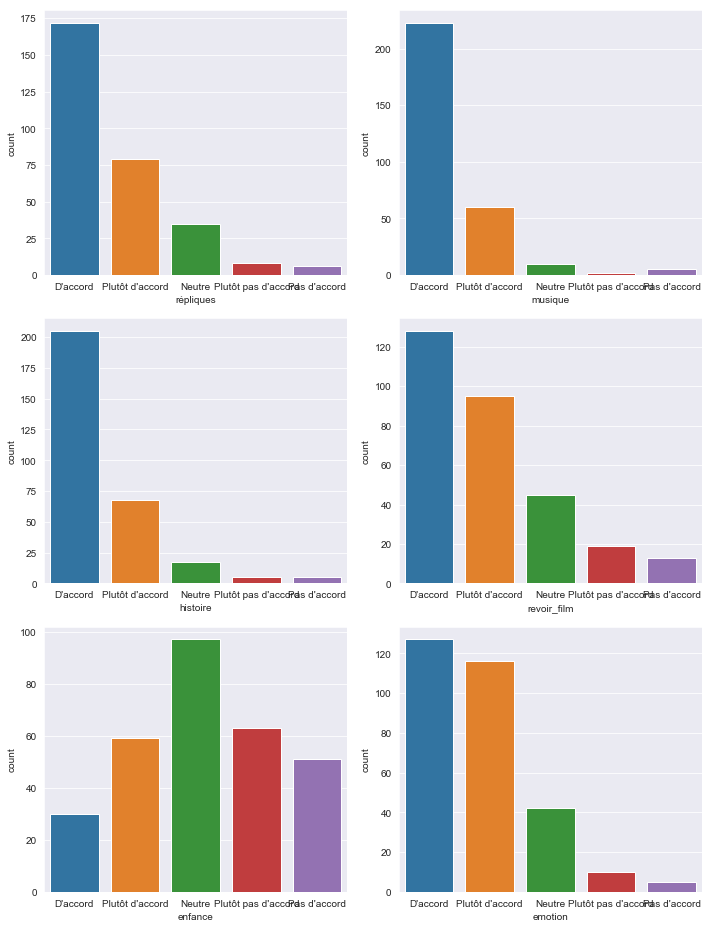

In [74]:
dataset = clean_data(dictt,NewColName)

df_stat,reponses,testChi2 = create_stat_df(dataset)

creating_count_plot(df_stat,reponses)

### Première série de test du chi deux 

In [85]:
def test_stat_chi_deux(testChi2,df_stat):
    dict_chi_deux = []
    for elem in testChi2:
        # On récupère la colonne correspondante
        current_array_test = df_stat[elem]
        # On fait le test du chi deux sur celui ci
        statistic,pvalue = chisquare(current_array_test)
        print("\nRésultat du test du chi deux pour la caractéristique",elem,"\n")
        print("statistic = ",statistic)
        print("p-value = ",pvalue)
        # On les met bout à bout pour faire un data frame et quelques figures 
        dict_chi_deux.append(pvalue)
    return dict_chi_deux

In [87]:
dict_chi_deux = test_stat_chi_deux(testChi2,df_stat)

df_chi_deux = pd.DataFrame(dict_chi_deux)
df_chi_deux.set_axis(['p-value'], axis = 1, inplace= True)
print('\n############################################\n', '\nDataframe de p-values: \n\n', df_chi_deux)


Résultat du test du chi deux pour la caractéristique répliques 

statistic =  319.16666666666663
p-value =  7.934862367902722e-68

Résultat du test du chi deux pour la caractéristique musique 

statistic =  590.9666666666667
p-value =  1.3970730777864903e-126

Résultat du test du chi deux pour la caractéristique histoire 

statistic =  483.1333333333334
p-value =  2.9768762081112325e-103

Résultat du test du chi deux pour la caractéristique revoir_film 

statistic =  166.06666666666666
p-value =  7.303534923049034e-35

Résultat du test du chi deux pour la caractéristique enfance 

statistic =  39.33333333333333
p-value =  5.944914651338685e-08

Résultat du test du chi deux pour la caractéristique emotion 

statistic =  224.56666666666663
p-value =  1.9504460548835097e-47

############################################
 
Dataframe de p-values: 

          p-value
0   7.934862e-68
1  1.397073e-126
2  2.976876e-103
3   7.303535e-35
4   5.944915e-08
5   1.950446e-47


C:\Users\mbach\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


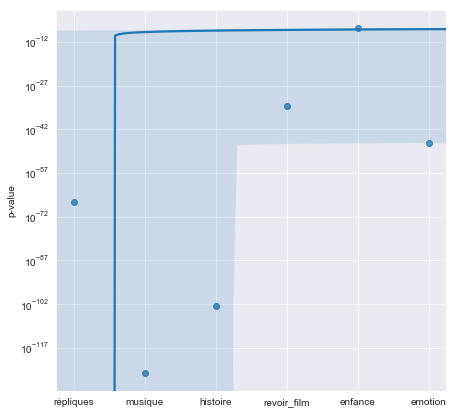

In [107]:
def plot_log(df_chi_deux,testChi2,refut_pvalue=False):
    f, ax = plt.subplots(figsize=(7, 7))
    # Etant donné les valeurs de p-value obtenue il faut une échelle logarithmique
    ax.set(yscale="log")
    # J'ai ajouté un élément inutile pour redécaler les légendes vers la droite 
    # (on ne voyait pas répliques avant)
    ax.set_xticklabels([''] + testChi2)
    xaxis = [i for i in range(6)]
    sns.regplot(x=xaxis, y='p-value', data=df_chi_deux, ax=ax)
    if refut_pvalue == True:
        # Cette option sert à afficher une ligne rouge ou se situe le seuil de 5% pour la p-value 
        seuil_cinq_pourcent = [0.05 for i in xaxis]
        plt.plot(xaxis,seuil_cinq_pourcent,'r')
plot_log(df_chi_deux,testChi2)

### Test du chi deux sur les deux plus grandes proportions  

In [103]:
dict_snd_chi_deux = {}
for key in testChi2:
    value = []
    
    # On stocke le maximum de cette colonne
    list_inter = list(df_stat[key])
    maxi = max(list_inter)
    value.append(maxi)
    
    # On stocke le maximum de cette colonne après avoir supprimé le précédent maximum
    list_inter.remove(maxi)
    maxi = max(list_inter)
    value.append(maxi)
    
    dict_snd_chi_deux[key] = value

# On crée le data frame
df_inter_chi_deux = pd.DataFrame(dict_snd_chi_deux)
print(df_inter_chi_deux)

   répliques  musique  histoire  revoir_film  enfance  emotion
0        172      223       205          128       97      127
1         79       60        68           95       63      116


In [100]:
dict_plot_snd_chi_deux = test_stat_chi_deux(testChi2,df_inter_chi_deux)

df_plot_snd_chi_deux = pd.DataFrame(dict_plot_snd_chi_deux)
df_plot_snd_chi_deux.set_axis(['p-value'], axis = 1, inplace= True)
print('\n#####################################\n', '\nDataframe de p-values: \n\n', df_plot_snd_chi_deux)


Résultat du test du chi deux pour la caractéristique répliques 

statistic =  34.45816733067729
p-value =  4.35511478276811e-09

Résultat du test du chi deux pour la caractéristique musique 

statistic =  93.88339222614842
p-value =  3.3467043489786993e-22

Résultat du test du chi deux pour la caractéristique histoire 

statistic =  68.75091575091575
p-value =  1.1171897958417422e-16

Résultat du test du chi deux pour la caractéristique revoir_film 

statistic =  4.883408071748879
p-value =  0.02711602906411855

Résultat du test du chi deux pour la caractéristique enfance 

statistic =  7.225
p-value =  0.00718951725016505

Résultat du test du chi deux pour la caractéristique emotion 

statistic =  0.49794238683127573
p-value =  0.48040561742029564

#####################################
 
Dataframe de p-values: 

         p-value
0  4.355115e-09
1  3.346704e-22
2  1.117190e-16
3  2.711603e-02
4  7.189517e-03
5  4.804056e-01


C:\Users\mbach\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


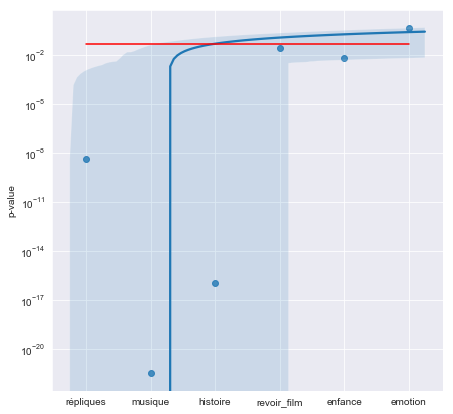

In [108]:
plot_log(df_plot_snd_chi_deux,testChi2,True)